In [1]:
import warnings
warnings.simplefilter("always")

# Run this again after editing submodules so Colab uses the updated versions
from citylearn import  CityLearn
from pathlib import Path
from TD3 import Agent as Agent
import numpy as np                                                                                                                                                                                      
import torch
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from utils import agent_checkpoint_cost
import seaborn as sns
import os

/Users/qasimwani/opt/anaconda3/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [2]:
# Load environment
climate_zone = 1
end_time = 2189 # total number of hours to train for
cost_analysis = 24 # analyze costs every x hours
checkpoint = 24 # save parameters every x hours

params = {'data_path':Path("data/Climate_Zone_"+str(climate_zone)), 
        'building_attributes':'building_attributes.json', 
        'weather_file':'weather_data.csv', 
        'solar_profile':'solar_generation_1kW.csv', 
        'carbon_intensity':'carbon_intensity.csv',
        'building_ids':["Building_"+str(i) for i in [1,2,3,4,5,6,7,8,9]],
        'buildings_states_actions':'buildings_state_action_space.json', 
        'simulation_period': (0, end_time), 
        'cost_function': ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','carbon_emissions'], 
        'central_agent': False,
        'cost_analysis' : cost_analysis,
        'save_memory': False }

# Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
env = CityLearn(**params)
env.pretrain_baseline_model((0, end_time))

observations_spaces, actions_spaces = env.get_state_action_spaces()

# Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
building_info = env.get_building_information()

Time taken to add RBC pretrained model (sec): 4.713


In [3]:
def get_mse_critic():
    if not agent.did_i_just_finish_training():
            return None, None
    try:
        data = {}
        NUM_DAYS = len(agent.critic_optim.debug['ramping_cost'])

        for key, _d in agent.critic_optim.debug.items():
            data[key] = []
            for day in _d:
                data[key].append(day.value)
            data[key] = np.reshape(data[key], (NUM_DAYS * 24))

        rc = data['ramping_cost']
        peak = data['peak_net_electricity_cost']
        ec = data['electricity_cost']

        A = np.vstack((-rc, -peak)).T
        y = np.reshape(agent.critic_optim.problem.param_dict['y_r'].value, (NUM_DAYS * 24))

        x, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)
        # print(f"Rank: {rank}\tCondition Number: {np.linalg.cond(A)}")
        # print(f"MSE across {NUM_DAYS} days: {round(np.linalg.norm(A@x - y), 5)}")
        return round(np.linalg.norm(A@x - y), 5), round(np.linalg.cond(A), 3)
    except:
        return None, None

In [4]:
env._get_ob().shape

(9, 30)

In [5]:
params_agent = {'building_ids':["Building_"+str(i) for i in [1,2,3,4,5,6,7,8,9]],
                 'buildings_states_actions':'buildings_state_action_space.json', 
                 'building_info':building_info,
                 'observation_spaces':observations_spaces,
                 'agent_checkpoint' : checkpoint,
                 'action_spaces':actions_spaces}

# Instantiating the control agent(s)
rewards = []
critic_mse = [] # only last building to be added MSE will be recorded

agent = Agent(**params_agent)

state = env.reset()
done = False

ZO_iRL_costs = np.load("ZOiRL_cost_curve.npy")

with tqdm(total=end_time) as pbar:
    while not done:
        
        # get agent
        # day_type = env.buildings['Building_1'].sim_results['day'][env.time_step]
        # agent = agents.get_agent(day_type)
        # get agent
        
        action, _ = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.add_to_buffer(state, action, reward, next_state, done)
        state = next_state

        rewards.append(reward)

        try:
            mse, condition = get_mse_critic()
            pim = round(100 * (ZO_iRL_costs[env.time_step] - env.costs_periodic[-1]['total']) / ZO_iRL_costs[env.time_step], 3)
            txt = f"iAC: {round(env.costs_periodic[-1]['total'], 3)} , ZOiRL: {round(ZO_iRL_costs[env.time_step], 3)} , %ipr: {pim}"
            if len(critic_mse) > 0:
                txt += f", MSE: {round(critic_mse[-1][0], 3)} , CN: {round(critic_mse[-1][1], 3)}"
                
            if mse is not None:
                critic_mse.append([mse, condition])
                
            pbar.set_description(txt)
        except:
            pass
        
        pbar.update(1)

rewards = np.array(rewards)

iAC: 1.413 , ZOiRL: 1.406 , %ipr: -0.503:  22%|██▏       | 478/2189 [00:31<03:56,  7.25it/s] 

E2E	Building: 0, r: 22our: 23

iAC: 1.406 , ZOiRL: 1.403 , %ipr: -0.209:  22%|██▏       | 480/2189 [02:26<10:57:54, 23.10s/it]

Time taken for training: 115.59
Building 0: -385.473

iAC: 1.38 , ZOiRL: 1.373 , %ipr: -0.538, MSE: 1790.704 , CN: 21.614:  26%|██▌       | 574/2189 [02:43<02:57,  9.10it/s]   

E2E	Building: 0, r: 22our: 23

iAC: 1.372 , ZOiRL: 1.37 , %ipr: -0.132, MSE: 1790.704 , CN: 21.614:  26%|██▋       | 576/2189 [04:34<11:31:13, 25.71s/it]

Time taken for training: 110.91
Building 0: -386.061

iAC: 1.341 , ZOiRL: 1.337 , %ipr: -0.302, MSE: 586.296 , CN: 19.157:  31%|███       | 671/2189 [04:49<04:39,  5.43it/s]    

Time taken for training: 108.39
MODEL COSTS:

iAC: 1.337 , ZOiRL: 1.335 , %ipr: -0.111, MSE: 586.296 , CN: 19.157:  31%|███       | 672/2189 [06:38<12:01:14, 28.53s/it]

Building 0: -389.006

iAC: 1.29 , ZOiRL: 1.286 , %ipr: -0.257, MSE: 193.186 , CN: 15.987:  35%|███▍      | 766/2189 [06:53<02:48,  8.46it/s]    

E2E	Building: 0, r: 22our: 23

iAC: 1.281 , ZOiRL: 1.286 , %ipr: 0.381, MSE: 193.186 , CN: 15.987:  35%|███▌      | 768/2189 [08:46<10:16:51, 26.05s/it]

Time taken for training: 112.34
Building 0: -468.614

iAC: 1.263 , ZOiRL: 1.261 , %ipr: -0.155, MSE: 199.285 , CN: 53.291:  39%|███▉      | 863/2189 [09:02<02:18,  9.58it/s]  

E2E	Building: 0, r: 21our: 23

iAC: 1.258 , ZOiRL: 1.261 , %ipr: 0.173, MSE: 199.285 , CN: 53.291:  39%|███▉      | 864/2189 [10:50<9:54:25, 26.92s/it]

Time taken for training: 108.09
Building 0: -143.248

iAC: 1.251 , ZOiRL: 1.254 , %ipr: 0.249, MSE: 143.362 , CN: 20.999:  44%|████▍     | 959/2189 [11:05<02:07,  9.62it/s]  

E2E	Building: 0, r: 21our: 23

iAC: 1.251 , ZOiRL: 1.253 , %ipr: 0.131, MSE: 143.362 , CN: 20.999:  44%|████▍     | 960/2189 [12:49<8:48:26, 25.80s/it]

Time taken for training: 103.58
Building 0: -2386.152

iAC: 1.242 , ZOiRL: 1.241 , %ipr: -0.086, MSE: 1549.579 , CN: 52.021:  48%|████▊     | 1055/2189 [13:04<02:27,  7.68it/s]

E2E	Building: 0, r: 21our: 23

iAC: 1.239 , ZOiRL: 1.241 , %ipr: 0.12, MSE: 1549.579 , CN: 52.021:  48%|████▊     | 1056/2189 [14:52<8:30:18, 27.02s/it]

Time taken for training: 108.44
Building 0: -823.326

iAC: 1.236 , ZOiRL: 1.236 , %ipr: 0.004, MSE: 1488.374 , CN: 29.865:  53%|█████▎    | 1150/2189 [15:07<01:50,  9.39it/s]  

E2E	Building: 0, r: 21our: 23

iAC: 1.235 , ZOiRL: 1.235 , %ipr: 0.012, MSE: 1488.374 , CN: 29.865:  53%|█████▎    | 1152/2189 [16:51<5:57:42, 20.70s/it]

Time taken for training: 103.6
Building 0: -1051.585

iAC: 1.228 , ZOiRL: 1.23 , %ipr: 0.195, MSE: 176.498 , CN: 33.357:  57%|█████▋    | 1246/2189 [17:05<01:37,  9.65it/s]    

E2E	Building: 0, r: 22our: 23

iAC: 1.248 , ZOiRL: 1.23 , %ipr: -1.446, MSE: 176.498 , CN: 33.357:  57%|█████▋    | 1248/2189 [18:55<5:45:45, 22.05s/it]

Time taken for training: 110.4
Building 0: -1829.802

iAC: 1.245 , ZOiRL: 1.226 , %ipr: -1.544, MSE: 1279.467 , CN: 10.071:  61%|██████▏   | 1342/2189 [19:11<01:41,  8.34it/s]  

E2E	Building: 0, r: 21our: 23

iAC: 1.244 , ZOiRL: 1.226 , %ipr: -1.49, MSE: 1279.467 , CN: 10.071:  61%|██████▏   | 1344/2189 [21:06<6:14:44, 26.61s/it]

Time taken for training: 114.76
Building 0: -306.721

iAC: 1.242 , ZOiRL: 1.198 , %ipr: -3.725, MSE: 220.156 , CN: 37.701:  66%|██████▌   | 1439/2189 [21:21<01:19,  9.38it/s]   

E2E	Building: 0, r: 22our: 23

iAC: 1.217 , ZOiRL: 1.198 , %ipr: -1.614, MSE: 220.156 , CN: 37.701:  66%|██████▌   | 1440/2189 [23:17<6:01:33, 28.96s/it]

Time taken for training: 116.32
Building 0: -817.912

iAC: 1.203 , ZOiRL: 1.183 , %ipr: -1.743, MSE: 1693.754 , CN: 30.165:  70%|███████   | 1535/2189 [23:33<01:12,  9.05it/s]  

E2E	Building: 0, r: 21our: 23

iAC: 1.202 , ZOiRL: 1.183 , %ipr: -1.637, MSE: 1693.754 , CN: 30.165:  70%|███████   | 1536/2189 [25:22<5:57:07, 32.81s/it]

Time taken for training: 108.95
Building 0: -1104.369

iAC: 1.2 , ZOiRL: 1.179 , %ipr: -1.77, MSE: 145.698 , CN: 29.485:  74%|███████▍  | 1630/2189 [25:37<01:35,  5.87it/s]      

E2E	Building: 0, r: 22our: 23

iAC: 1.198 , ZOiRL: 1.179 , %ipr: -1.683, MSE: 145.698 , CN: 29.485:  75%|███████▍  | 1632/2189 [27:37<4:16:47, 27.66s/it]

Time taken for training: 119.09
Building 0: -559.204

iAC: 1.196 , ZOiRL: 1.176 , %ipr: -1.711, MSE: 262.902 , CN: 18.15:  79%|███████▉  | 1726/2189 [27:52<00:53,  8.69it/s]   

E2E	Building: 0, r: 22our: 23

iAC: 1.196 , ZOiRL: 1.176 , %ipr: -1.707, MSE: 262.902 , CN: 18.15:  79%|███████▉  | 1728/2189 [29:46<3:23:00, 26.42s/it]

Time taken for training: 113.95
Building 0: -793.591

iAC: 1.188 , ZOiRL: 1.182 , %ipr: -0.552, MSE: 590.632 , CN: 19.06:  83%|████████▎ | 1823/2189 [30:02<00:41,  8.86it/s]  

E2E	Building: 0, r: 22our: 23

iAC: 1.203 , ZOiRL: 1.181 , %ipr: -1.848, MSE: 590.632 , CN: 19.06:  83%|████████▎ | 1824/2189 [31:55<2:51:11, 28.14s/it]

Time taken for training: 112.98
Building 0: -406.393

iAC: 1.203 , ZOiRL: 1.18 , %ipr: -1.977, MSE: 174.318 , CN: 26.931:  88%|████████▊ | 1919/2189 [32:10<00:28,  9.36it/s]   

E2E	Building: 0, r: 22our: 23

iAC: 1.202 , ZOiRL: 1.18 , %ipr: -1.886, MSE: 174.318 , CN: 26.931:  88%|████████▊ | 1920/2189 [34:03<2:06:01, 28.11s/it]

Time taken for training: 112.87
Building 0: -894.557

iAC: 1.204 , ZOiRL: 1.18 , %ipr: -2.015, MSE: 1032.556 , CN: 28.129:  92%|█████████▏| 2014/2189 [34:18<00:19,  9.12it/s]  

Time taken for training: 112.9
MODEL COSTS:

iAC: 1.197 , ZOiRL: 1.172 , %ipr: -2.107, MSE: 191.354 , CN: 29.859:  96%|█████████▋| 2111/2189 [36:27<00:09,  8.27it/s]  

Time taken for training: 113.24
Building 0: -7023.88

iAC: 1.193 , ZOiRL: 1.165 , %ipr: -2.346, MSE: 1338.84 , CN: 24.821: 100%|██████████| 2189/2189 [38:33<00:00,  1.06s/it]


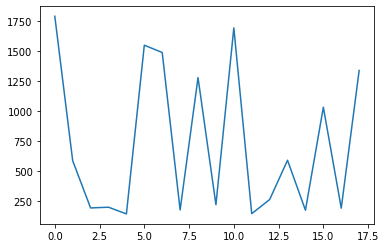

In [6]:
plt.plot(np.array(critic_mse)[:, 0])

In [7]:
np.array(critic_mse)[:, 0]

array([1790.7045 ,  586.2959 ,  193.18641,  199.28455,  143.36213,
       1549.57923, 1488.37428,  176.49838, 1279.46693,  220.15561,
       1693.75369,  145.69819,  262.90157,  590.63249,  174.31791,
       1032.55634,  191.35412, 1338.84025])

In [8]:
E_grid, E_grid_true, E_grid_prevhour = agent.critic_target[0].temp

In [9]:
agent.critic_optim.problem.param_dict['E_grid'].value

array([[ 0.38861327,  0.09586469,  0.08431648,  0.11143363,  0.09902776,
         0.16676937,  0.09276344, -0.14722484,  0.04588815, -0.12143462,
        -0.14481397,  0.67151239,  0.87457276,  0.49942449,  0.52521714,
         0.61573852,  0.11742558,  0.01337468,  0.25013485,  0.25011054,
         0.15564702,  0.03827953,  0.6609661 ,  0.06610081],
       [ 0.5246853 ,  0.65020052,  0.62121922,  0.16714821,  0.72954528,
         0.80390259,  1.2041047 ,  1.10373934,  0.04597907,  0.10599393,
         1.0315079 ,  0.6391084 ,  0.65346836,  0.49942108,  0.89306527,
         0.78162103,  0.70967064,  0.28723812,  0.25038575,  0.27149077,
         0.14227214,  0.03828356,  0.66078655,  0.63780368],
       [ 0.42227534,  0.99907202,  0.82695001,  0.05179244,  0.94940575,
         1.1329965 ,  0.89049743,  1.15483528,  0.04589704,  0.30116652,
         0.39088377,  0.6368939 ,  0.53435562,  0.5233133 ,  0.87651943,
         0.85819926,  0.71326099,  1.04399616,  0.25505538,  0.25842055,
  

In [10]:
E_grid_prevhour.shape

(24,)

In [11]:
agent.critic[0].normalize(E_grid_true[:, 0], _E_grid)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
agent.memory.sample()[0][0]["E_grid_pkhist"].shape

In [ ]:
x = agent.actor.debug[0](*agent.actor.debug[1].values())[0]

In [ ]:
x.detach().numpy()

In [ ]:
agent.critic_optim.test['E_grid'].min()

In [ ]:
x.data = torch.tensor(agent.critic[0].normalize(x.detach().numpy(), x.detach().numpy()))

In [ ]:
agent.critic_optim.problem.param_dict['E_grid'].value.min()

In [ ]:
agent.critic[0].debug

In [ ]:
i=23
agent.critic[0].prob[i].solve('SCS')

In [ ]:
agent.critic[0].prob[i].solve('SCS', eps=5e-2)

In [ ]:
x = agent.critic[0].prob[i]

In [ ]:
-r * ramping_cost - electricity_cost

In [ ]:
x.solve(solver='SCS', max_iters=10_000_000, eps=5e-2)

In [ ]:
np.sum(e[t:] * E_grid)

In [ ]:
_type = 0
Q_value, ramping_cost, peak_hist_cost, electricity_cost, E_grid, E_grid_true, E_grid_prevhour, (bid, t) = agent.critic_target[_type].debug
r, e = agent.critic[_type].alpha_ramp[bid], agent.critic[_type].alpha_elec[bid]

In [ ]:
Q_value

In [ ]:
np.mean(agent.actor._grads[0]['p_ele_grad'], 1)

In [ ]:
plt.plot(np.array(critic_mse)[:, 0])
plt.xlabel("Meta-episode #")
plt.ylabel("Cost")

In [ ]:
agent.actor.debug[1]["E_grid_prevhour"]

In [ ]:
np.array(rewards)[23:, 0].sum()

In [ ]:
np.shape(critic_mse)

In [ ]:
for k, v in agent.actor._losses.items():
    print(k, v)

In [ ]:
np.array(rewards).sum(0)

In [ ]:
total = [x["total"] for x in env.costs_periodic]

In [ ]:
round(100 * (ZO_iRL_costs[2189] - total[2189//24]) / ZO_iRL_costs[2189//24], 3)

In [ ]:
np.mean(agent.actor._grads[0]['p_ele_grad'], 1)

In [ ]:
env.cost_detailed_view()['Building_9']['cost']

In [ ]:
env.cost((0, end_time))

In [ ]:
plt.plot(total, label="iAC")
plt.plot(ZO_iRL_costs[::24][1:], label="ZOiRL")
plt.legend()
plt.ylim(0.96, 1.5)
plt.xlabel("Day")
plt.ylabel("Cost")
plt.show()

In [ ]:
np.where(ZO_iRL_costs[::24][1:] < total)

In [ ]:
a, b = agent.memory.sample()

In [ ]:
len(b)

In [ ]:
data = {}
NUM_DAYS = len(agent.critic_optim.debug['ramping_cost'])

for key, _d in agent.critic_optim.debug.items():
    data[key] = []
    for day in _d:
        data[key].append(day.value)
    data[key] = np.reshape(data[key], (NUM_DAYS * 24))

In [ ]:
agent.critic[0].alpha_ramp

In [ ]:
rc = data['ramping_cost']
peak = data['peak_net_electricity_cost']
ec = data['electricity_cost']

A = np.vstack((-rc, -peak)).T
y = np.reshape(agent.critic_optim.problem.param_dict['y_r'].value, (NUM_DAYS * 24))

x, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)
print(f"Rank: {rank}\tCondition Number: {np.linalg.cond(A)}")
print(f"MSE across {NUM_DAYS} days: {round(np.linalg.norm(A@x - y), 5)}")

plt.plot(A@x, label='y_hat')
plt.plot(y, label='y')
plt.legend()
plt.xlabel("Hours")
plt.ylabel("Q-value")
plt.show()

In [ ]:
(A@x).max(), y.max()

In [ ]:
p = agent.critic_optim.problem

In [ ]:
p.solve()

In [ ]:
import cvxpy
for i in range(len(p.constraints)):
    x = p.constraints[i]
    if isinstance(x.args[0], cvxpy.atoms.affine.add_expr.AddExpression):
        assert x.args[0].value <= 1, (i, x.args[0].value)

In [ ]:
agent.critic[0].alpha_ramp, agent.critic[0].alpha_peak1

In [ ]:
agent.critic_target[0].alpha_ramp, agent.critic_target[0].alpha_peak1

In [ ]:
agent.memory.replay_memory[0]['E_grid']

In [ ]:
agent.critic[0].alpha_ramp

In [ ]:
_t = np.array(agent._actor_zetas['p_ele_local']).T

In [ ]:
plt.scatter(range(24), agent.actor.zeta['p_ele'][:, 0], c='k', label="Iteration 3")
plt.bar(range(24), _t[0, :, 0], label="Initial")
plt.bar(range(24), _t[0, :, 1], label="Iteration 1")
plt.bar(range(24), _t[0, :, 2], label="Iteration 2")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=4)
plt.show()

In [ ]:
#set seaborn plotting aesthetics as default
sns.set(rc={'figure.figsize':(5,5)})
df = np.array(agent._actor_zetas['p_ele_local'])
df = np.append(df, np.expand_dims(agent.actor.zeta['p_ele'], 0)).reshape((9, 24, 9)).T

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, ax in enumerate(axn.flat):
    sns.heatmap(df[i], ax=ax,
                cbar=i == 0,
                cmap='viridis',
                cbar_ax=None if i else cbar_ax)
    ax.set(title=f"Building {i + 1}")

axn.flat[0].set(ylabel='Hour of Day')
axn.flat[2].set(ylabel='Hour of Day')
axn.flat[2].set(xlabel='Month')
axn.flat[3].set(xlabel='Month')


fig.tight_layout(rect=[0, 0, .9, 1])

In [ ]:
plt.bar(range(24), agent.actor.zeta['p_ele'][:, 0])

In [ ]:
np.array(agent._actor_zetas["p_ele_local"])[:, :, 0].min(1)

In [ ]:
np.array(agent._actor_zetas["p_ele_target"])[:, :, 0].min(1)

In [ ]:
agent.actor.scs_cnt, agent.actor.fail_cnt, agent.critic_optim.fail_cnt

In [ ]:
agent.actor.zeta["p_ele"][:, 0]

In [ ]:
agent.critic[0].alpha_peak1

In [ ]:
agent.critic_target[0].alpha_peak1

In [ ]:
agent.actor.zeta

In [ ]:
t = np.random.rand(101, 30)

In [ ]:
v = np.expand_dims(t, axis=(2, 3))

In [ ]:
np.linalg.matrix_rank(t)

In [ ]:
total[100]